<a href="https://colab.research.google.com/github/happyrabbit/IntroDataScience/blob/master/Python/DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing Notebook

In this notebook, we will show how to use python to preprocess the data. 

In [35]:
# Load packages
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import scale, power_transform
from sklearn.feature_selection import VarianceThreshold
from scipy import stats
from statistics import mean
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
from sklearn.impute import KNNImputer
from mlxtend.plotting import scatterplotmatrix
import seaborn as sns

# Read data
dat = pd.read_csv("http://bit.ly/2P5gTw4")
dat[:6]

,age,gender,income,house,store_exp,online_exp,store_trans,online_trans,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,segment
0,57,Female,120963.400958,Yes,529.134363,303.512475,2,2,4,2,1,2,1,4,1,4,2,4,Price
1,63,Female,122008.104950,Yes,478.005781,109.529710,4,2,4,1,1,2,1,4,1,4,1,4,Price
2,59,Male,114202.295294,Yes,490.810731,279.249582,7,2,5,2,1,2,1,4,1,4,1,4,Price
3,60,Male,113616.337078,Yes,347.809004,141.669752,10,2,5,2,1,3,1,4,1,4,2,4,Price
4,51,Male,124252.552787,Yes,379.625940,112.237177,4,4,4,1,1,3,1,4,1,4,2,4,Price
5,59,Male,107661.456130,Yes,338.315403,195.687013,4,5,4,2,1,2,1,4,1,4,1,4,Price


# 01 Data Cleaning

After you load the data, the first thing is to check how many variables are there, the type of variables, the distributions, and data errors. You can get descriptive statistics of the data using `describe()` function:

In [86]:
dat.describe()

,age,income,store_exp,online_exp,store_trans,online_trans,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
count,1000.000000,816.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,38.840000,113543.065222,1356.850523,2120.181187,5.350000,13.546000,3.101000,1.823000,1.992000,2.763000,2.945000,2.448000,3.434000,2.396000,3.085000,2.320000
std,16.416818,49842.287197,2774.399785,1731.224308,3.695559,7.956959,1.450139,1.168348,1.402106,1.155061,1.284377,1.438529,1.455941,1.154347,1.118493,1.136174
min,16.000000,41775.637023,-500.000000,68.817228,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,25.000000,85832.393634,204.976456,420.341127,3.000000,6.000000,2.000000,1.000000,1.000000,2.000000,1.750000,1.000000,2.500000,1.000000,2.000000,1.000000
50%,36.000000,93868.682835,328.980863,1941.855436,4.000000,14.000000,3.000000,1.000000,1.000000,3.000000,4.000000,2.000000,4.000000,2.000000,4.000000,2.000000
75%,53.000000,124572.400926,597.293077,2440.774823,7.000000,20.000000,4.000000,2.000000,3.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
max,300.000000,319704.337941,50000.000000,9479.442310,20.000000,36.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


You can check missing value and column type quickly using `info()`:

In [88]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1000 non-null   int64  
 1   gender        1000 non-null   object 
 2   income        816 non-null    float64
 3   house         1000 non-null   object 
 4   store_exp     1000 non-null   float64
 5   online_exp    1000 non-null   float64
 6   store_trans   1000 non-null   int64  
 7   online_trans  1000 non-null   int64  
 8   Q1            1000 non-null   int64  
 9   Q2            1000 non-null   int64  
 10  Q3            1000 non-null   int64  
 11  Q4            1000 non-null   int64  
 12  Q5            1000 non-null   int64  
 13  Q6            1000 non-null   int64  
 14  Q7            1000 non-null   int64  
 15  Q8            1000 non-null   int64  
 16  Q9            1000 non-null   int64  
 17  Q10           1000 non-null   int64  
 18  segment       1000 non-null  

Are there any problems? Questionnaire response Q1-Q10 seem reasonable, the minimum is 1 and maximum is 5. Recall that the questionnaire score is 1-5. The number of store transactions (`store_trans`) and online transactions (`online_trans`) make sense too. Things to pay attention are:

1. There are some missing values.
2. There are outliers for store expenses (store_exp). The maximum value is 50000. Who would spend $50000 a year buying clothes?! 
3. There is a negative value ( -500) in store_exp which is not logical.
Someone is 300 years old.
4. How to deal with that? Depending on the real situation, if the sample size is large enough, it does not hurt to delete those problematic samples. Here we have 1000 observations. Since marketing survey is usually expensive, it is better to set these values as missing and impute them instead of deleting the rows.

In [89]:
# set problematic values as missings
dat.loc[dat.age > 100, 'age'] = np.nan
dat.loc[dat.store_exp < 0, 'store_exp'] = np.nan
dat.loc[dat.income.isnull(), 'income'] = np.nan
# see the results
# some of the values are set as NA
dat[['income','age', 'store_exp']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   income     816 non-null    float64
 1   age        999 non-null    float64
 2   store_exp  999 non-null    float64
dtypes: float64(3)
memory usage: 23.6 KB


# 02-Missing Value

## 02.1-Impute missing values with `median`, `mode`, `mean`, or `constant`

You can set the imputation strategy using `strategy` argument.

- If “`mean`”, then replace missing values using the mean along each column. Can only be used with numeric data.
- If “`median`”, then replace missing values using the median along each column. Can only be used with numeric data.
- If “`most_frequent`”, then replace missing using the most frequent value along each column. Can be used with strings or numeric data.
- If “`constant`”, then replace missing values with fill_value. Can be used with strings or numeric data.


In [90]:
impdat = dat[['income','age','store_exp']]
imp_mean = SimpleImputer(strategy="mean")
imp_mean.fit(impdat)
impdat = imp_mean.transform(impdat)

In [91]:
impdat = pd.DataFrame(data=impdat, columns=["income", "age",'store_exp'])
impdat.head()

,income,age,store_exp
0,120963.400958,57.0,529.134363
1,122008.104950,63.0,478.005781
2,114202.295294,59.0,490.810731
3,113616.337078,60.0,347.809004
4,124252.552787,51.0,379.625940


Let us replace the columns in `dat` with the imputed columns.

In [84]:
# replace the columns in `dat` with the imputed columns
dat2 = dat.drop(columns = ['income','age','store_exp'])
dat_imputed = pd.concat([dat2.reset_index(drop=True), impdat] , axis=1)
dat_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        1000 non-null   object 
 1   house         1000 non-null   object 
 2   online_exp    1000 non-null   float64
 3   store_trans   1000 non-null   int64  
 4   online_trans  1000 non-null   int64  
 5   Q1            1000 non-null   int64  
 6   Q2            1000 non-null   int64  
 7   Q3            1000 non-null   int64  
 8   Q4            1000 non-null   int64  
 9   Q5            1000 non-null   int64  
 10  Q6            1000 non-null   int64  
 11  Q7            1000 non-null   int64  
 12  Q8            1000 non-null   int64  
 13  Q9            1000 non-null   int64  
 14  Q10           1000 non-null   int64  
 15  segment       1000 non-null   object 
 16  income        1000 non-null   float64
 17  age           1000 non-null   float64
 18  store_exp     1000 non-null  

## 02.2-K-nearest neighbors

In [2]:
impdat = dat[['income','age','store_exp']]
imp_knn = KNNImputer(n_neighbors=2, weights="uniform")
impdat = imp_knn.fit_transform(impdat)
impdat = pd.DataFrame(data=impdat, columns=["income", "age",'store_exp'])
impdat.head()

,income,age,store_exp
0,120963.400958,57.0,529.134363
1,122008.104950,63.0,478.005781
2,114202.295294,59.0,490.810731
3,113616.337078,60.0,347.809004
4,124252.552787,51.0,379.625940


In [3]:
# replace the columns in `dat` with the imputed columns
dat2 = dat.drop(columns = ['income','age','store_exp'])
dat_imputed = pd.concat([dat2.reset_index(drop=True), impdat] , axis=1)
dat_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        1000 non-null   object 
 1   house         1000 non-null   object 
 2   online_exp    1000 non-null   float64
 3   store_trans   1000 non-null   int64  
 4   online_trans  1000 non-null   int64  
 5   Q1            1000 non-null   int64  
 6   Q2            1000 non-null   int64  
 7   Q3            1000 non-null   int64  
 8   Q4            1000 non-null   int64  
 9   Q5            1000 non-null   int64  
 10  Q6            1000 non-null   int64  
 11  Q7            1000 non-null   int64  
 12  Q8            1000 non-null   int64  
 13  Q9            1000 non-null   int64  
 14  Q10           1000 non-null   int64  
 15  segment       1000 non-null   object 
 16  income        1000 non-null   float64
 17  age           1000 non-null   float64
 18  store_exp     1000 non-null  

# 03-Centering and Scaling

Let’s standardize variables `income` and `age` from imputed data `dat_imputed`. 

- `axis`: axis used to compute the means and standard deviations along. If 0, standardize each column, otherwise(if 1) each row.
- `with_mean`: if True, center the data before scaliing
- `with_std`: if True, scale the data to unit standard deviation.

In [4]:
dat_s = dat_imputed[['income', 'age']]
dat_sed = scale(dat_s,  axis = 0, with_mean = True, with_std = True)

After centering and scaling, the features are with mean 0 and standard deviation 1. 

In [8]:
dat_sed = pd.DataFrame(data=dat_sed, columns=["income", "age"])
dat_sed.describe()

,income,age
count,1.000000e+03,1.000000e+03
mean,2.660649e-16,-1.370015e-16
std,1.000500e+00,1.000500e+00
min,-1.501074e+00,-1.391952e+00
25%,-5.806889e-01,-8.434598e-01
50%,-4.062407e-01,-1.730799e-01
75%,2.192401e-01,8.629617e-01
max,4.250212e+00,1.591604e+01


# 04-Resolve Skewness

We can use `sklearn.preprocessing.power_transform` to resolve skewness in the data. Currently, `power_transform` supports the Box-Cox transform and the Yeo-Johnson transform. The optimal parameter for stabilizing variance and minimizing skewness is estimated through maximum likelihood. Let's apply Box-Cox transformation.

In [9]:
dat_skew = dat_imputed[['income', 'age']]
dat_skew_res = power_transform(dat_skew, method = 'box-cox')

In [11]:
dat_skew_res = pd.DataFrame(data=dat_skew_res, columns=["income", "age"])

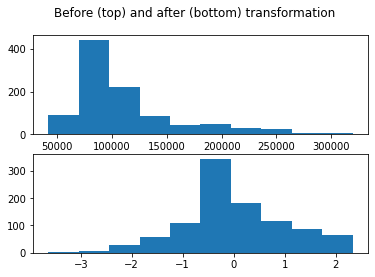

In [17]:
fig, axs = plt.subplots(2)
fig.suptitle('Before (top) and after (bottom) transformation')
axs[0].hist(dat_imputed.income)
axs[1].hist(dat_skew_res.income)
plt.show()

# 05-Resolve Outliers

Box plot, histogram and some other basic visualizations can be used to initially check whether there are outliers. For example, we can visualize numerical non-survey variables using scatter matrix plot:

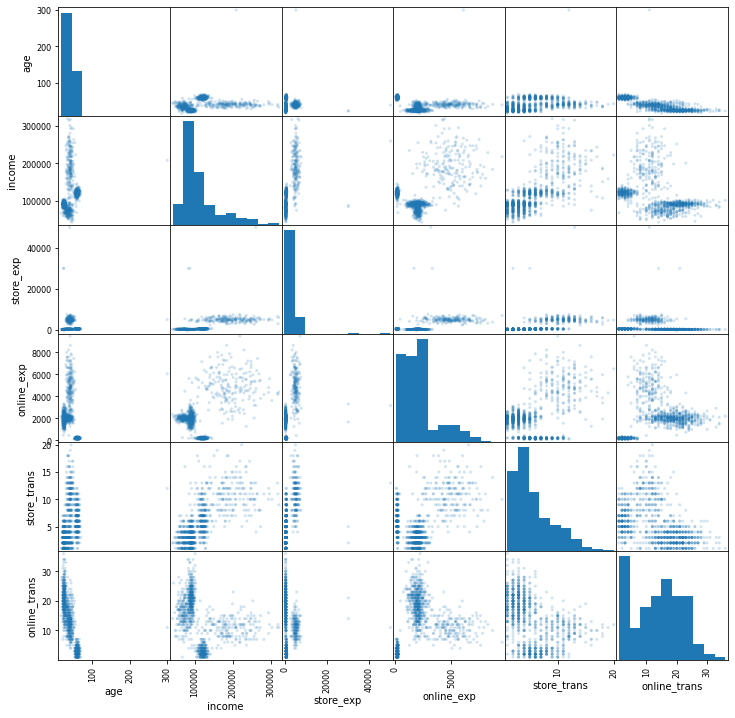

In [22]:
# select numerical non-survey data
subdat = dat_imputed[["age", "income", "store_exp", 
    "online_exp", "store_trans", "online_trans"]]
subdat = pd.DataFrame(data=subdat, columns=["age", "income", "store_exp", 
    "online_exp", "store_trans", "online_trans"])
plts = pd.plotting.scatter_matrix(subdat, alpha=0.2, figsize = (12,12))

Let us use MAD (section 5.5 of the book) to detect ourliers. The result here is slightly different because we use the imputed data `dat_imputed` here.


In [27]:
# calculate median of the absolute dispersion for income
income = dat_imputed.income
ymad = stats.median_absolute_deviation(income)
# calculate z-score
zs = (income - mean(income))/ymad
# count the number of outliers
sum(zs > 3.5)

51

# 06-Collinearity

Checking correlations is an important part of the exploratory data analysis process. In python, you can visualize correlation structure of a set of predictors using [seaborn](https://seaborn.pydata.org) library.

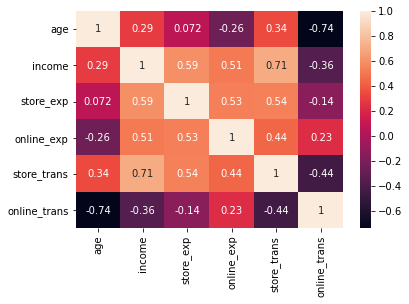

In [50]:
# select non-survey numerical variables
df = dat_imputed[["age", "income", "store_exp", "online_exp", "store_trans", "online_trans"]]
df = pd.DataFrame(df, columns = ["age", "income", "store_exp", "online_exp", "store_trans", "online_trans"])
cor_plot = sns.heatmap(df.corr(), annot = True)

The closer the correlation is to 0, the lighter the color is. Let us write a `findCorrelation()` function to remove a minimum number of predictors to ensure all pairwise correlations are below a certain threshold.

In [51]:
## Drop out highly correlated features in Python
def findCorrelation(df, cutoff = 0.8):
    """
    Given a numeric pd.DataFrame, this will find highly correlated features,
    and return a list of features to remove
    params:
    - df : pd.DataFrame
    - cutoff : correlation threshold, will remove one of pairs of features with
               a correlation greater than this value
    """
    # Create correlation matrix
    corr_matrix = df.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than cutoff
    to_drop = [column for column in upper.columns if any(upper[column] > cutoff)]
    return(to_drop)

Remove the columns:

In [52]:
removeCols = findCorrelation(df, cutoff = 0.7)
print(removeCols)
df1 = df.drop(columns = removeCols) 
# check the new cor matrix
df1.corr()

['store_trans', 'online_trans']


,age,income,store_exp,online_exp
age,1.000000,0.286468,0.071618,-0.256114
income,0.286468,1.000000,0.594594,0.511080
store_exp,0.071618,0.594594,1.000000,0.534909
online_exp,-0.256114,0.511080,0.534909,1.000000


# 07-Sparse Variables

In [57]:
# create a data frame with sparse variables
col1 = [0,0,0,0,1,1,0,0,0,0,0,0,]
col2 = range(0,len(col1))
a_dict = {"col1":col1,  "col2":col2}
df = pd.DataFrame(a_dict)
df

,col1,col2
0,0,0
1,0,1
2,0,2
3,0,3
4,1,4
5,1,5
6,0,6
7,0,7
8,0,8
9,0,9


Define a function to remove columns that have a low variance. An instance of the class can be created specify the “threshold” argument, which defaults to 0.0 to remove columns with a single value.

In [58]:
def variance_threshold_selector(df, threshold=0):
    """
    Given a numeric pd.DataFrame, this will remove columns that have a low variance and the return 
    the resulted dataframe
    params:
    - df : input dataframe from which to compute variances.
    - threshold : Features with a training set variance lower than this threshold will be removed. 
                  The default is to keep all features with non-zero variance, i.e. remove the features 
                  that have the same value in all samples.
    """
    selector = VarianceThreshold(threshold)
    selector.fit(df)
    res = df[df.columns[selector.get_support(indices=True)]]
    return res

In [59]:
# apply the function to the generated data set
variance_threshold_selector(df, threshold = 0.2)

,col2
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


# 08-Encode Dummy Variables

Let’s encode `gender` and `house` from `dat_imputed` to dummy variables. You can use `get_dummies` function from `pandas`:

In [62]:
df = dat_imputed[['gender', 'house']]
pd.get_dummies(df).head()

,gender_Female,gender_Male,house_No,house_Yes
0,1,0,0,1
1,1,0,0,1
2,0,1,0,1
3,0,1,0,1
4,0,1,0,1
